# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL (Extract, Transform, Load) pipeline.

* [1. Data Wrangling](#1.) - with import libraries, gather and cleaning datasets
* [2. Exploratory Data Analysis (EDA)](#2.) - with data exploration including statistics and visualisations
* [3. Load](#3.) - save the cleaned dataset in an SQL database

**My note:**<br>
In general, the dataset would be prepared to remove irrelevant or redundant data. In this project, especially regarding the second part - the ML pipeline - this would destroy the goal of this Udacity project. Therefore it is required not to change the existing amount of categories.

---
<a id='1.'></a>

## 1. Data Wrangling
In this section of the project, first the datasets are loaded, a brief overview of the data structure is given and the general properties of the data are checked. Then the datasets are merged.

Have in mind, we are working with a multi-labelled classification task. For each observation the classification prediction may include several available categories.

### 1.1 Import Libraries and Load Datasets
- Import Python libraries
- Installation of a specific language library used for language detection
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [1]:
#
# import libraries
#
import numpy as np
import pandas as pd
import pandas_profiling
import collections
import random

# for storage of the cleaned dataset in a SQL database
from sqlalchemy import create_engine

# for language detection
from langdetect import detect, DetectorFactory

# for visualisation
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

C:\anaconda\anaconda3\lib\site-packages\astropy\config\configuration.py:532: ConfigurationMissingWarning: Configuration defaults will be used due to PermissionError:13 on None
  warn(ConfigurationMissingWarning(msg))


#### `Messages` Dataset

In [2]:
# load messages dataset
try:
    messages = pd.read_csv('messages.csv')
except FileNotFoundError:
    print("The csv file 'messages.csv' does not exist in the given directory. No analysis possible.")
    
# success
print("The messages dataset has {} data points with {} variables each.".format(*messages.shape))

The messages dataset has 26248 data points with 4 variables each.


In [3]:
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
id          26248 non-null int64
message     26248 non-null object
original    10184 non-null object
genre       26248 non-null object
dtypes: int64(1), object(3)
memory usage: 820.3+ KB


<b>Note:</b><br>
Now, we are doing some more data analysis on this messages dataset, regarding the following questions:
- What kind of genre exists?
- As we can see from the information above, there are original languages, means not all messages are originally in English. But having 26248 entries altogether and also 26248 message items, we have to proof if all this message items are in English, means it is expected that the original messages are translated properly. Have in mind that for simplification of this project, only English text messages are investigated.

##### Genre

In [5]:
# genre values
messages['genre'].unique()

array(['direct', 'social', 'news'], dtype=object)

In [6]:
genre = messages.groupby('genre').size()
dict_genre = genre.to_dict()
dict_genre

{'direct': 10782, 'news': 13068, 'social': 2398}

<b>Note:</b> The genre of the messages before cleaning is grouped in:<br>
- 2398 social messages
- 10782 direct messages
- 13068 news messages

##### Languages
The next topic are the languages: Are all message texts in English? They shall be used for text analysis. The indexing shall not be changed, because this analysis happened before both datasets are merged. Language coding interpretation can be found on the following [website](https://www.loc.gov/standards/iso639-2/php/code_list.php).

In [7]:
# see: https://pypi.org/project/langdetect/
# Language detection algorithm is non-deterministic, which means that if you try to run it on a text which is either
# too short or too ambiguous, you might get different results everytime you run it.
# Therefore the DetectorFactory.seed is necessary.

DetectorFactory.seed = 14

def select_language_codes(df_source):
    message_subset = df_source['message']
    languages = []
    for message in message_subset.values:  # [100:120]:  note: index 117: French message; toDo: could be used for unit test
        try:
            if message in (None, ''):
                lang_code = None
            else:
                lang_code = detect(message)
        except:
            lang_code = None
        languages.append(lang_code)
        #print("message: {} - lang_code: {}".format(message, lang_code))
        
    return languages

In [8]:
languages = select_language_codes(messages)

In [9]:
messages['lang_code'] = languages
messages.head(120)

,id,message,original,genre,lang_code
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,en
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,en
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,en
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,en
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,en


<b>Note:</b><br>
We realise that the language decoder software has some weakness analysing the message text values, because e.g. the index row 117 is properly mapped to coding 'fr' for French, but index row 2 is incorrectly mapped to 'no' - Norwegian language - instead of correct 'en' coding for English.

In [10]:
messages.shape

(26248, 5)

In [11]:
messages['lang_code'].nunique()

28

So, there are 28 different languages realised, but which one and how much of each?

In [12]:
messages['lang_code'].value_counts()

en    25829
fr       57
de       54
pt       35
id       34
nl       32
af       30
so       28
es       23
it       18
da       16
vi       13
ca       12
tl       10
no        8
et        7
sq        7
cy        6
sw        5
tr        4
sv        3
pl        3
fi        3
sl        2
ro        1
sk        1
hu        1
hr        1
Name: lang_code, dtype: int64

Example:

In [13]:
# proof if the language detection is correctly mapped to the associated message text
messages.query('lang_code == "pl"')

,id,message,original,genre,lang_code
5978,6802,gjm.adgjmpgjm.adgjmgjmgjmgjmgjmgkmptwptwptwptw...,gjm. adgjmpgjm. adgjmgjmgjmgjmgjmgkmptwptwptwp...,direct,pl
8154,9141,/''''''''@''''''''''''''''@ @''''' michou )) '...,/''''''''@''''''''''''''''@ @''''' michou ) ) ...,direct,pl
8174,9162,/''''''''@''''''''''''''''@ @''''' michou )) '...,/''''''''@''''''''''''''''@ @''''' michou ) ) ...,direct,pl


This 'nonsense' text messages are wrongly classified to be Polish language.

<b>Note:</b><br>
We realise there are rows having no English message. As listed, there are several languages used. As one root cause, the original message of the different language is not translated. Another possible case could be that the message value is an empty string or that an exception appeared during language code detection. For this last-mentioned cases the feature value of the language code is set to 'None'. 

Another reason is as seen above, that 'nonsense' text messages exists somewhere in the dataset. If they are mapped to another language then English, fine, they will be part of the cleaning process. If there are still 'en' classified text messages which are 'nonsense', we have to take care during the NLP pipeline, e.g. by usage of regular expressions.

Additionally, there could be other language coding issues, which may lead the message text to be mapped to a different language coding than English code 'en':<br>
- misspellings in the message text items
- the message text is e.g. a web link or an abbreviation sequence
- e.g. the original text message is in Frensh and as far as it can be seen correctly translated in English. The language coding library could lead to a wrong mapping of the message language code because of software weakness. It should be 'en', but the detection library has selected a different one.
- there is no original text (value is set to NaN, means None in this case), and the message text is directly stored in the message column, even being in a different language compared to English

In this project part, this both non-English row cases - different language or None message value - are removed from the dataset as cleaning step after the merge of messages and categories datasets. Regarding the found text issues, this is a simplifiction which in reality needs further 'toDo'. It is possible that rows are removed which are correctly translated to English. We expect that this amount is not a huge one and accept it, because there are still more than 25000 'en' items. In general, for NLP text tasks a much higher amount of data are expected.

<b>Remark:</b><br>
We have in mind, that there is probably a more reliable language coding library. Unfortunately, <i>polyglot</i> and <i>spacy</i> including all dependencies could not be installed only by using simple <i>conda</i> or <i>pip</i> commands on a Windows OS machine on terminal level. Perhaps their language detector coding is much better, but because of the project timeframe this is a future follow-up task.

#### `Categories` Dataset

In [14]:
# load categories dataset
try:
    categories = pd.read_csv('categories.csv')
except FileNotFoundError:
    print("The csv file 'categories.csv' does not exist in the given directory. No analysis possible.")  
    
# success
print("The categories dataset has {} data points with {} variables each.".format(*categories.shape))

The categories dataset has 26248 data points with 2 variables each.


In [15]:
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [16]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
id            26248 non-null int64
categories    26248 non-null object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


<b>Note:</b><br>
It is obvious that we have to do some cleaning here, this happens below after merging. For example, the categorical 'category' features shall be represented by integers, not by strings and we create one column for each unique category feature. We want to have a tidy dataset, where according Hadley Wickham i.a. each variable is a column and each observation is a row. Such datasets are easier to model and visualise.

### 1.2 Merge Datasets
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [17]:
messages['id'].equals(categories['id'])

True

In [18]:
# merge datasets
df = messages.merge(categories, on='id')
df.head()

,id,message,original,genre,lang_code,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en,related-1;request-0;offer-0;aid_related-0;medi...


### 1.3 Clean: Split `categories` into Separate Category Columns
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [19]:
# create a dataframe of the 36 individual category columns
categories = categories['categories'].str.split(pat=";", expand=True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [20]:
# select the first row of the categories dataframe
row = categories.head(1).values
row

array([['related-1', 'request-0', 'offer-0', 'aid_related-0',
        'medical_help-0', 'medical_products-0', 'search_and_rescue-0',
        'security-0', 'military-0', 'child_alone-0', 'water-0', 'food-0',
        'shelter-0', 'clothing-0', 'money-0', 'missing_people-0',
        'refugees-0', 'death-0', 'other_aid-0',
        'infrastructure_related-0', 'transport-0', 'buildings-0',
        'electricity-0', 'tools-0', 'hospitals-0', 'shops-0',
        'aid_centers-0', 'other_infrastructure-0', 'weather_related-0',
        'floods-0', 'storm-0', 'fire-0', 'earthquake-0', 'cold-0',
        'other_weather-0', 'direct_report-0']], dtype=object)

In [21]:
# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing

category_colnames = []
# the row variable itself has length 1, but the one row has 36 category elements
for i in range(len(row[0])):
    s = pd.Series([row[0][i]])
    colname = s.str.split(pat='-', n=1)
    category_colnames.append(colname[0][0])
    
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [22]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 1.4 Clean: Convert Category Values to Numbers 0 or 1
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [23]:
for column in categories:
    # set each value to be the last character of the string
    # convert column from string to numeric
    categories[column] =  categories[column].str.split("-").str[1].astype('int64')

categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 36 columns):
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null int64
money                     26248 non-null int64
missing_people            26248 non-null int64
refugees                  26248 non-null int64
death                     26248 non-null int64
other_aid                 26248 non-null int6

So, all feature values are integers, means they have the expected data type, all items are filled with a value and no missing ones are available. But are all integer values are only 0 or 1?

In [25]:
categories.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.0,...,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000
mean,0.774002,0.170680,0.004534,0.414432,0.079511,0.050061,0.027583,0.017944,0.032764,0.0,...,0.011772,0.043851,0.278269,0.082216,0.093264,0.010744,0.093531,0.020192,0.052423,0.193577
std,0.435472,0.376236,0.067181,0.492633,0.270540,0.218075,0.163778,0.132751,0.178023,0.0,...,0.107862,0.204767,0.448155,0.274698,0.290808,0.103095,0.291181,0.140659,0.222883,0.395108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Note:</b><br>
Surprisingly, for the column related the maximum value is 2. Expected is only 0 and 1 for this feature: if the feature has the value 1, the message is classified to be a disaster message. If it is 0, all other features shall have the value 0, which finally means the message is not a disaster message.

So, we will explore the column related more detailed now.

In [26]:
categories['related'].value_counts(sort=False)

0     6125
1    19930
2      193
Name: related, dtype: int64

In [27]:
df_related_2 = categories.query('related == 2')
df_related_2.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
460,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, visualise the different category content values '0', '1' and '2' for each category. Are there other columns having values greater 1? If the dictionary value lists for the other features include only the two integer values (counts of content 0 and 1), the answer is no.

In [28]:
category_content_names = ['0', '1', '2']

dict_category_content_values = {}
categories_columns = sorted(categories.columns)
for column in categories_columns:
    dict_category_content_values[column] = categories[column].value_counts(sort=False).values.tolist()
print(dict_category_content_values)

{'aid_centers': [25939, 309], 'aid_related': [15370, 10878], 'buildings': [24913, 1335], 'child_alone': [26248], 'clothing': [25842, 406], 'cold': [25718, 530], 'death': [25052, 1196], 'direct_report': [21167, 5081], 'earthquake': [23793, 2455], 'electricity': [25714, 534], 'fire': [25966, 282], 'floods': [24090, 2158], 'food': [23318, 2930], 'hospitals': [25965, 283], 'infrastructure_related': [24543, 1705], 'medical_help': [24161, 2087], 'medical_products': [24934, 1314], 'military': [25388, 860], 'missing_people': [25949, 299], 'money': [25644, 604], 'offer': [26129, 119], 'other_aid': [22800, 3448], 'other_infrastructure': [25097, 1151], 'other_weather': [24872, 1376], 'refugees': [25372, 876], 'related': [6125, 19930, 193], 'request': [21768, 4480], 'search_and_rescue': [25524, 724], 'security': [25777, 471], 'shelter': [23929, 2319], 'shops': [26128, 120], 'storm': [23800, 2448], 'tools': [26089, 159], 'transport': [25045, 1203], 'water': [24574, 1674], 'weather_related': [18944,

In [29]:
#labels = list(dict_category_content_values.keys())
#labels

In [31]:
#data = list(dict_category_content_values.values())
#pd.DataFrame(data=data).cumsum(axis=1)

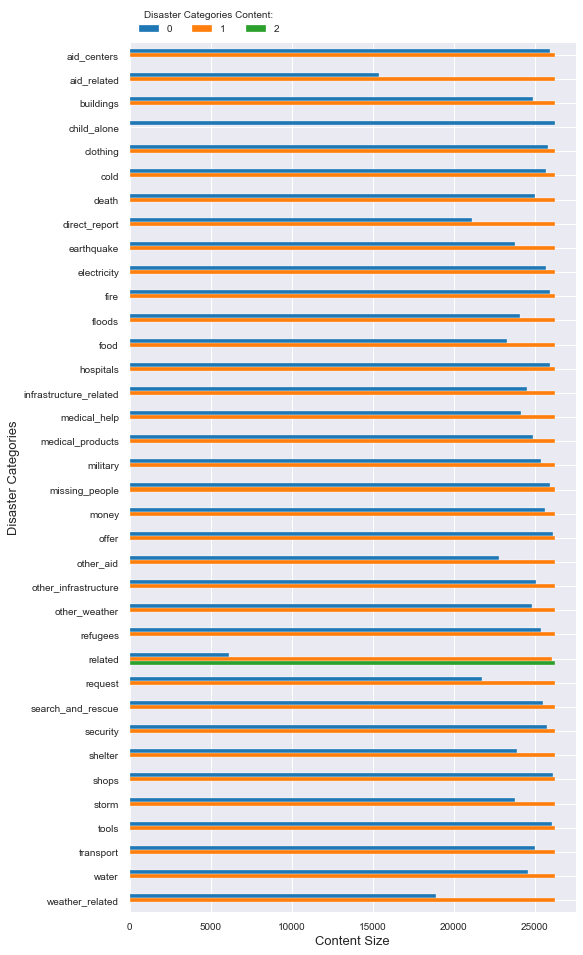

In [29]:
# Visualise the amount of each category content 0, 1 or 2
index = list(dict_category_content_values.keys())
data = list(dict_category_content_values.values())
df_cat = pd.DataFrame(data=data, index=index).cumsum(axis=1)
ax = df_cat.plot.barh(figsize=[8,16])  # Figure dimension (width, height) in inches
ax.set_xlabel('Content Size', fontsize=13)
ax.set_ylabel('Disaster Categories', fontsize=13)
ax.invert_yaxis()
ax.legend(ncol=len(category_content_names), bbox_to_anchor=(0, 1), loc='lower left',
          fontsize=10, title='Disaster Categories Content:');  # with ; <matplotlib.legend.Legend at ...> text not shown

<b>Note:</b><br>
As we can see, there is only one column including the content 2, this column is called 'related'.<br>
Additionally, the column 'child_alone' is the only one, including only one bar for the content 0. But this seems not reliable, because in a disaster situation there are probably children which are alone without other family members. Nevertheless, with future new data this could be different, therefore the column is not removed.

This needs some more investigation, starting with the question why exists a related value of 2? What does it mean?

First, we clarify what are the values of the other category observations regarding the items with 'related' category feature value 2. The 5 examples rows above let us assume that the other category values are always 0. We have to validate this assumption. 

In [30]:
dict_df_related_2 = {}
for column in df_related_2.columns:
    dict_df_related_2[column] = df_related_2[column].unique()

In [31]:
# remove the category feature 'related' from this subset, we are only interested on the other categories
del dict_df_related_2['related']

In [32]:
related2_keys = list(dict_df_related_2.keys())
related2_values = list(dict_df_related_2.values())

for i in range(len(related2_keys)):
    print("{} has value(s) {}".format(related2_keys[i], related2_values[i]))

request has value(s) [0]
offer has value(s) [0]
aid_related has value(s) [0]
medical_help has value(s) [0]
medical_products has value(s) [0]
search_and_rescue has value(s) [0]
security has value(s) [0]
military has value(s) [0]
child_alone has value(s) [0]
water has value(s) [0]
food has value(s) [0]
shelter has value(s) [0]
clothing has value(s) [0]
money has value(s) [0]
missing_people has value(s) [0]
refugees has value(s) [0]
death has value(s) [0]
other_aid has value(s) [0]
infrastructure_related has value(s) [0]
transport has value(s) [0]
buildings has value(s) [0]
electricity has value(s) [0]
tools has value(s) [0]
hospitals has value(s) [0]
shops has value(s) [0]
aid_centers has value(s) [0]
other_infrastructure has value(s) [0]
weather_related has value(s) [0]
floods has value(s) [0]
storm has value(s) [0]
fire has value(s) [0]
earthquake has value(s) [0]
cold has value(s) [0]
other_weather has value(s) [0]
direct_report has value(s) [0]


<b>Note:</b><br>
Our former assumption that all other category values are 0 is true. Means the associated message is not a disaster message and the value 2 is probably a mistake. Therefore, we change it to be 0 instead of 2.

In [33]:
categories['related'].replace([2], 0, inplace=True)

In [34]:
# Test if only 0 and 1 appeared as 'related' feature values
categories['related'].value_counts()

1    19930
0     6318
Name: related, dtype: int64

Now, we proof if all rows with related value 0, have only associated category features with value 0.

In [35]:
df_related_0 = categories.query('related == 0')
dict_df_related_0 = {}
for column in df_related_0.columns:
    dict_df_related_0[column] = df_related_0[column].unique()

In [36]:
dict_df_related_0

{'related': array([0], dtype=int64),
 'request': array([0], dtype=int64),
 'offer': array([0], dtype=int64),
 'aid_related': array([0], dtype=int64),
 'medical_help': array([0], dtype=int64),
 'medical_products': array([0], dtype=int64),
 'search_and_rescue': array([0], dtype=int64),
 'security': array([0], dtype=int64),
 'military': array([0], dtype=int64),
 'child_alone': array([0], dtype=int64),
 'water': array([0], dtype=int64),
 'food': array([0], dtype=int64),
 'shelter': array([0], dtype=int64),
 'clothing': array([0], dtype=int64),
 'money': array([0], dtype=int64),
 'missing_people': array([0], dtype=int64),
 'refugees': array([0], dtype=int64),
 'death': array([0], dtype=int64),
 'other_aid': array([0], dtype=int64),
 'infrastructure_related': array([0], dtype=int64),
 'transport': array([0], dtype=int64),
 'buildings': array([0], dtype=int64),
 'electricity': array([0], dtype=int64),
 'tools': array([0], dtype=int64),
 'hospitals': array([0], dtype=int64),
 'shops': array([0

Fine, all values are correctly set to 0. In other words, no item with related value 0 is set incorrectly and no cleaning step is necessary.

Regarding the specific category features, one of them seems to be different: <i>'direct_report'</i>. All others have something to do with a disaster situation, but this one seems to be another genre type, because it deals with communication. So, we will have a look to some of the items where its value is 1.

In [37]:
categories.groupby('related')['direct_report'].value_counts()

related  direct_report
0        0                 6318
1        0                14849
         1                 5081
Name: direct_report, dtype: int64

So, there are only direct report (feature value is 1) if the message is of related category value 1 as well, means it is a disaster message. We will not change this now, because it is expected that with the implemented feature engineering concept of the ML pipeline, this category will be removed.

### 1.5 Clean: Replace `categories` Column in `df` with New Category Columns
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [38]:
# drop the original categories column from `df`
df.drop(columns=['categories'], inplace=True)
df.head()

,id,message,original,genre,lang_code
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en


In [39]:
# concatenate the original dataframe with the new `categories` dataframe
df = df.merge(categories, left_index=True, right_index=True)
df.head()

,id,message,original,genre,lang_code,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26248 entries, 0 to 26247
Data columns (total 41 columns):
id                        26248 non-null int64
message                   26248 non-null object
original                  10246 non-null object
genre                     26248 non-null object
lang_code                 26243 non-null object
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null 

### 1.6 Clean: Remove Duplicates and Non-English Items
- Check how many duplicates are in this dataset
- Drop the duplicates
- Confirm duplicates were removed
- Detect the language code of the message column
- Filter only having the 'en' English messages
- Check that only 'en' language coding is available

If something went wrong during further dataset cleaning, start with creating a data frame copy.

In [41]:
df_copy = df.copy()

##### Duplicates

In [42]:
# check number of duplicates
sum(df.duplicated())

43

In [43]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [44]:
# check number of duplicates
sum(df.duplicated())

0

In [45]:
print("After removing the duplicate items, the dataframe includes {} rows.".format(df.shape[0]))

After removing the duplicate items, the dataframe includes 26205 rows.


##### Non-English messages

In [46]:
df['lang_code'].value_counts()

en    25783
fr       59
de       54
pt       35
id       34
nl       32
af       30
so       29
es       23
it       18
da       16
vi       13
ca       12
tl       10
no        8
et        7
sq        7
cy        6
sw        5
tr        4
sv        3
pl        3
fi        3
sl        2
ro        1
sk        1
hu        1
hr        1
Name: lang_code, dtype: int64

In [47]:
df_en = df.query('lang_code == "en"')
df_en['lang_code'].unique()

array(['en'], dtype=object)

In [48]:
print("After selecting all English coded message items, the dataframe includes {} rows.".format(df_en.shape[0]))

After selecting all English coded message items, the dataframe includes 25783 rows.


### 1.7 Clean: Compare Categories Meaning

Now after merging and first cleaning steps, are there intercorrelations between the category features? In other words, are the features which don't have added values, because they are already explained by the other features? Redundant or irrelevant information could be removed, other ones could be merged to one column because they express the same topic. Having in mind that there are a lot of target category features and the amount of messages input is not huge. As a rule-of-thumb there should be at least 100 proper input items for 1 target feature. This is not the case for the given dataset having 36 category types. So, feature reduction would improve the projects classification task. E.g. it reduces the complexity of predictive model by having less data. 

Again, here is the overview of all data frame columns:

In [49]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25783 entries, 0 to 26247
Data columns (total 41 columns):
id                        25783 non-null int64
message                   25783 non-null object
original                  9918 non-null object
genre                     25783 non-null object
lang_code                 25783 non-null object
related                   25783 non-null int64
request                   25783 non-null int64
offer                     25783 non-null int64
aid_related               25783 non-null int64
medical_help              25783 non-null int64
medical_products          25783 non-null int64
search_and_rescue         25783 non-null int64
security                  25783 non-null int64
military                  25783 non-null int64
child_alone               25783 non-null int64
water                     25783 non-null int64
food                      25783 non-null int64
shelter                   25783 non-null int64
clothing                  25783 non-null i

##### direct_report
Is our former assumption correct, that this feature should not be a classification target feature, but is another genre type?

We start with the general distribution of all direct_report items and their given genre type.

In [50]:
df_en.groupby('direct_report')['genre'].value_counts()

direct_report  genre 
0              news      12095
               direct     6941
               social     1782
1              direct     3570
               news        848
               social      547
Name: genre, dtype: int64

Followed by the association between the messages having a <i>'direct_report'</i> value of 1, because relevant for projects classification task are only real disaster messages.

In [51]:
df_messages_directreport_1 = df_en.query('direct_report == 1')
df_messages_directreport_1.head(10)

,id,message,original,genre,lang_code,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,en,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
10,20,"There's nothing to eat and water, we starving ...",Bon repo pa gen anyen menm grangou swaf,direct,en,1,1,0,1,1,...,0,1,1,1,0,0,0,0,0,1
12,22,"I am in Thomassin number 32, in the area named...",Mwen thomassin 32 nan pyron mwen ta renmen jwe...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
13,24,"Let's do it together, need food in Delma 75, i...",Ann fel ansanm bezwen manje nan delma 75 nan r...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
15,26,"A Comitee in Delmas 19, Rue ( street ) Janvier...",Komite katye delma 19 rue janvier imp charite ...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
16,27,We need food and water in Klecin 12. We are dy...,Nou bezwen mange avek dlo nan klcin 12 LA LAFI...,direct,en,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
21,33,"I'm in Laplaine, I am a victim",Mwen laplan mwen viktim kot yap bay d pou latr...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
22,34,"There's a lack of water in Moleya, please info...",Nan moleya pa gen dlo svp f konnen sa pou mwen.,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
26,38,"People I'm at Delma 2, we don't anything what ...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL N...,direct,en,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In general, we would remove this column now, but as mentioned, this is not the goal of the project and the column shall stay in the dataset.

But there is no added value for having the <b><i>'id'</i></b> column, after merge of both datasets. For all observations already the index information is available. Therefore, we remove this column now.

In [52]:
df_en = df_en.drop(columns=['id'])

**Other categories** could be thematically grouped as well:
- Human status
- Infrastructure
- Weather
- Aid

The <i>human status</i> information - child_alone, missing_people, refugees, death - are all unique, they stay unchanged. 

Here is the status for the infrastructure elements. We take care of it later.
- <i>'infrastructure'</i> related columns (i.a. basics of a (national) economy) are:
    - aid_centers
    - buildings
    - clothing
    - electricity
    - food
    - hospitals
    - infrastructure_related
    - money    
    - other_infrastructure
    - shelter    
    - transport
    - water

We take care about the <i>'weather'</i> related columns.
- Weather:
    - cold
    - earthquake
    - fire
    - floods
    - other_weather
    - storm
    - weather_related
    
Regarding this list, the elements <i>other_weather - weather_related</i>, <i>other_infrastructure - related_infrastructure</i> and <i> other_aid - aid_related</i> don't offer more detailed information comparing this domain pairs. No real difference about this labels exists. In real life, we would clean this aspect and merge them if necessary. As already mentioned, for this project we will not change this now, because it is expected that with the implemented feature engineering concept of the ML pipeline, the irrelevant categories will be removed.

After we have created a (partly) cleaned dataset, we continue to work with it doing some EDA. 

<a id='2.'></a>
## 2. Exploratory Data Analysis (EDA)

In this chapter, we move on to data exploration. Statistics and visualisations are created, starting with some general data information. If we detect other issues to improve the cleaning, it will be done too.

### 2.1 General Overview

In [64]:
print("The cleaned dataset has {} data points with {} variables each.".format(*df_en.shape))

The cleaned dataset has 25783 data points with 37 variables each.


In [65]:
df_en.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,tools,hospitals,shops,aid_centers,weather_related,floods,storm,fire,earthquake,cold
count,25783.000000,25783.000000,25783.000000,25783.000000,25783.00000,25783.000000,25783.000000,25783.000000,25783.000000,25783.0,...,25783.000000,25783.000000,25783.000000,25783.000000,25783.000000,25783.000000,25783.00000,25783.000000,25783.000000,25783.000000
mean,0.761510,0.169647,0.004538,0.416127,0.08013,0.050304,0.027848,0.018113,0.033239,0.0,...,0.006128,0.010976,0.004577,0.011946,0.279719,0.082613,0.09386,0.010937,0.093938,0.020479
std,0.426169,0.375329,0.067212,0.492925,0.27150,0.218577,0.164540,0.133362,0.179263,0.0,...,0.078043,0.104193,0.067497,0.108644,0.448870,0.275301,0.29164,0.104011,0.291748,0.141633
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### 2.2 Some Visualisations
<b> First question:</b> How many items are a disaster message the organisations have to react on and how many are not?

In [53]:
def plot_feature_bar(dict, titel, xlabel, ylabel, labels, figsize):
    # plot the dictionary keys as x params and the dictionary values as y params for the bar chart
    sorted_feature = sorted(dict.items(), key=lambda kv: kv[1])
    dict_sorted = collections.OrderedDict(sorted_feature)
    if labels in [None]:
        labels = list(dict_sorted.keys())
    values = list(dict_sorted.values())

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=90)
    ax.bar(labels, values, alpha=0.8)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set
    fig.suptitle(titel, fontweight='bold')

In [54]:
dict_disaster_related = df_en.groupby('related').size().to_dict()
dict_disaster_related

{0: 6149, 1: 19634}

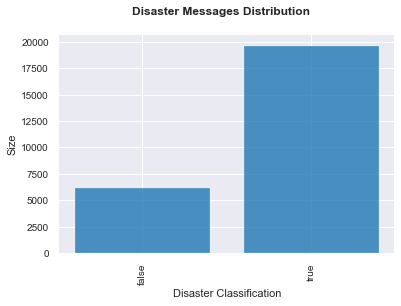

In [55]:
plot_feature_bar(dict_disaster_related,
                 'Disaster Messages Distribution', 'Disaster Classification', 'Size', ['false', 'true'], None)

<b>Second question:</b> How many genre types are available?<br>
Above in project chapter 1, we have analysed the available genre types and their numerical amount before cleaning. Now, this distribution is visualised after cleaning of the merged dataset.

In [56]:
dict_df_genre = df_en.groupby('genre').size().to_dict()
dict_df_genre

{'direct': 10511, 'news': 12943, 'social': 2329}

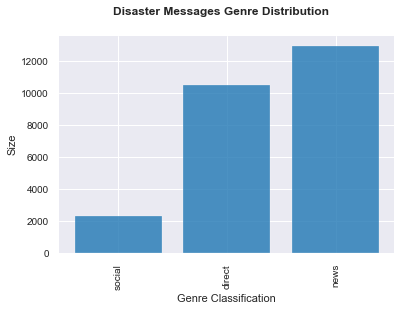

In [57]:
plot_feature_bar(dict_df_genre, 'Disaster Messages Genre Distribution', 'Genre Classification', 'Size', None, None)

<b>Third question: </b> What is the distribution of the remaining category features?<br>
If it is a disaster - in other words, the related feature is set to 1 - at least one of the other category features must have an attribute value of 1. We know already that the category 'child_alone' is not part of the disaster messages, there only zero values appeared. But this column is still part of the dataset, because this status may change with future data items.

In [58]:
df_related_1 = df_en.query("related == 1")

In [59]:
dict_cat = df_related_1.iloc[:, 5:].sum().to_dict()
dict_cat

{'request': 4374,
 'offer': 117,
 'aid_related': 10729,
 'medical_help': 2066,
 'medical_products': 1297,
 'search_and_rescue': 718,
 'security': 467,
 'military': 857,
 'child_alone': 0,
 'water': 1650,
 'food': 2885,
 'shelter': 2281,
 'clothing': 401,
 'money': 598,
 'missing_people': 297,
 'refugees': 872,
 'death': 1187,
 'other_aid': 3392,
 'infrastructure_related': 1688,
 'transport': 1197,
 'buildings': 1313,
 'electricity': 528,
 'tools': 158,
 'hospitals': 283,
 'shops': 118,
 'aid_centers': 308,
 'other_infrastructure': 1136,
 'weather_related': 7212,
 'floods': 2130,
 'storm': 2420,
 'fire': 282,
 'earthquake': 2422,
 'cold': 528,
 'other_weather': 1366,
 'direct_report': 4965}

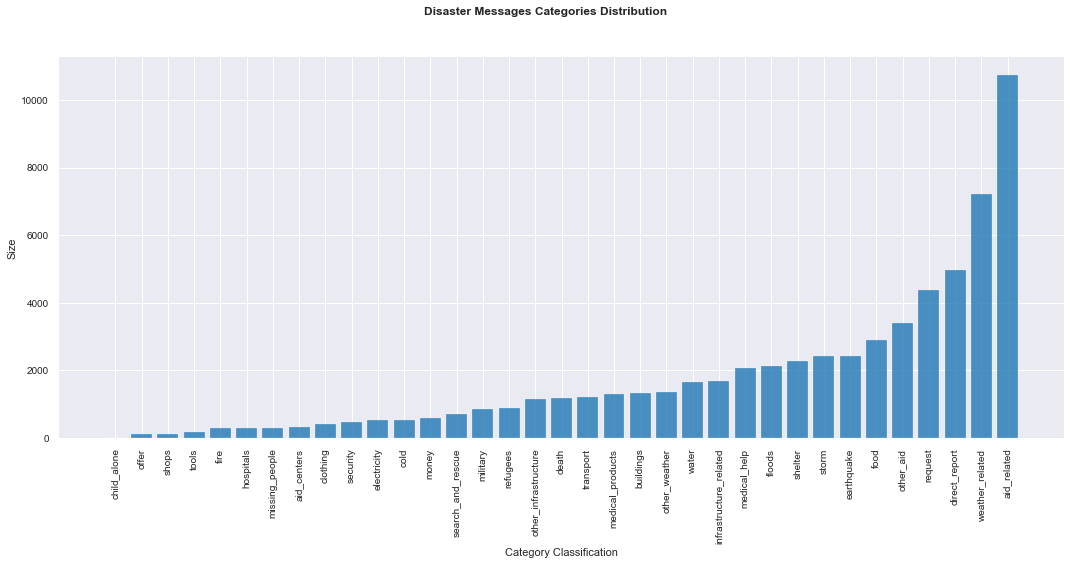

In [60]:
plot_feature_bar(dict_cat, 'Disaster Messages Categories Distribution', 'Category Classification', 'Size', None, (18, 7))

It is clearly visible that this is an imbalanced dataset for the multi-label message classification task, so, we have to take care by chosing an appropriate model. If we use a model type getting unreliable evaluation results, we have to change the dataset being a more balanced one or to trigger specific algorithms for model architecture. 

Regarding the model handling, we have to take care about the real disaster messages, because the non-disaster messages are unlabelled regarding the category targets. Furthermore, there could be messages classified as a disaster one, means related is set to 1, but no detailed target category is mapped. This could be an issue during model evaluation of the next ML pipeline file. Regarding its included classification metric report, UndefinedMetricWarning's could be thrown: "Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples."

In other words, for our dataset only the observations with related value 1 and  possible mapped category labels are of interest and we will see, if this is an issue during the ML pipeline.

But could we improve the situtation, by reducing the amount of categories: E.g. are there any kind of correlations? We don't want to remove them, but want to compare the result of the ETL pipeline with the result of the ML pipeline file.

In [61]:
# reduce the dataframe to the category columns
df_en_cat = df_en.iloc[:, 4:]
df_en_cat.head(2)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


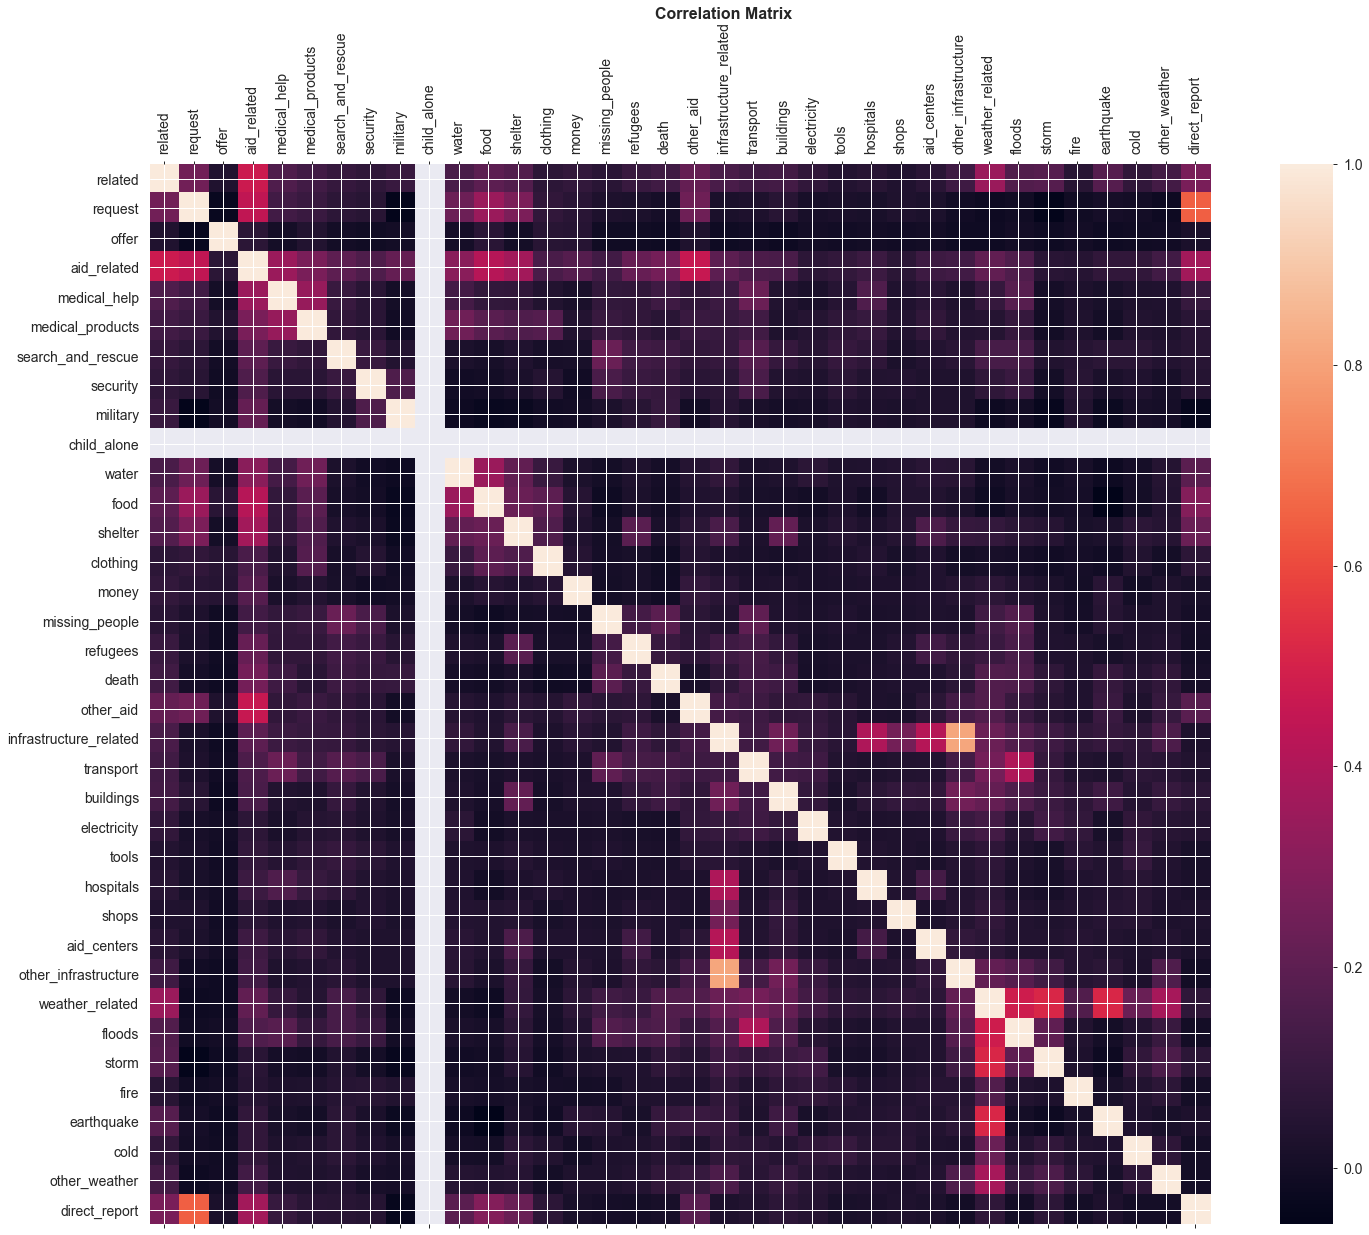

In [62]:
# see: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
fig = plt.figure(figsize=(25, 19))
fig.suptitle('Correlation Matrix', fontsize=16, fontweight='bold')
plt.matshow(df_en_cat.corr(), fignum=fig.number)
plt.xticks(range(df_en_cat.shape[1]), df_en_cat.columns, fontsize=14, rotation=90)
plt.yticks(range(df_en_cat.shape[1]), df_en_cat.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14);

Correlation values >0.8 are perhaps relevant. This fits to the <i>infrastructure features</i>. Around value 0.8 is the feature combination <i>direct_report and request</i>. The category <i>child_alone</i> is empty and therefore a grey column and row appeared.

<b>Additional investigation and cleaning step</b> for the category **<i>child_alone</i>**:<br>

**Note:** this is an additional aspect, that would happen in real life projects, but is not part of the Udacity project. For the project, we use this empty column.

Own interest:<br>
According the [red cross](https://www.icrc.org/en/what-we-do/restoring-family-links) during conflicts and disasters families are separated. And the [ICME](https://www.icmec.org/missing-children-statistics/) delivers terrifying statistics about missing children. 

[UNICEF](https://www.unicef.org/protection/57929_57994.html) informed that "In major humanitarian crises, as in Haiti following the earthquake in January 2010, thousands of children may be lost or missing their families. The longer a child is separated from her or his family, the more difficult it is to locate them and the more at risk a child is to violence, economic and sexual exploitation, abuse and potential trafficking. During emergencies, children want to be with their family and families want to be together.  Experience has shown that most separated children have parents or other family members willing and able to care for them."   

In their [annual report from 2018](https://www.unicef.org/media/55486/file/UNICEF-annual-report-2018%20revised%201.pdf) UNICEF stated:<br>
"Humanitarian action<br>
UNICEF reached 3.6 million children and adolescents affected by conflict and other emergencies with psychosocial support in 59 countries during 2018. ... In 37 countries – including Nigeria, Somalia and South Sudan – 61 per cent of the unaccompanied and separated children who registered with family tracing and reunification services were reunited with their families, received family-based care or had access to appropriate alternative services." 

So, it is not reliable that the 'child_alone' category is empty, because in an emergency case a child's vulnerability is increased. This is a very important category, that shall not be lost. Nevertheless, it is unclear how such kind of message would reach an organisation. It is expected, that UNICEF has its own process regarding this situations, but this details are unknown.

We start to check, if category value 0 fits to the messages or has it been forgotten to set the value to 1 for some row items?

In [63]:
# create a list with message search for some key words
df_social = df_en.query('genre == "social" or genre == "direct"')
child_alone_messages = []
for message in df_social['message']:
    if ('orphan' in message.lower() or 'child' in message.lower()) or \
       ('alone' in message.lower() or 'separate' in message.lower()):
        child_alone_messages.append(message)

There are some example messages stored in the new file <i>'childalone_sentences.txt'</i>, where the child_alone category should be 1 instead of 0.

In [77]:
#def set_child_alone(index, value):
#    df_en.loc[index:(index+1),['child_alone']] = value
#    df_en.iloc[index:(index+1), :]

In [64]:
# create a new dataframe out of the new text file with the few sentences
f = open('childalone_sentences.txt', 'r')
list_childsentences = f.read().splitlines()  # not readlines(), because then the carriage return is included
f.close()
# list_childsentences   # the messsages are listed with their original '' or "" signs

df_childalone = pd.DataFrame()
df_childalone['message'] = list_childsentences
df_childalone.shape

(14, 1)

In [65]:
for message in df_childalone.values:
    print(message)

["Please I am alone and I'd like to know if there is somebody out there who would like to adopt an adolescent please adopt me."]
['SOS, SOS. 27 month old child in difficulties at Cap-haitien. We need diapers, milk and protein. Thank you for your help.']
['How can a child to to they USA right now if his people/family is there.']
["I am a child. My leg is broken. Please send me some food so I don't die. "]
['Is there any help in place for orphans? My mother and father have died in the tragedy.']
['. ..  3106 childrens, 2353 childrens with one parents, 206 orphans, 257 young, more than 500 families, 1189 adults, 152 elderly persons, 4000 refugees. .. . .. ']
['hI am an orphan. I have finished school. I cannot find anything. Do something for me.']
['anyone to help me please see what you can do for me please i have no one they didnt show me any other family im so alone i have no idea what to do im praying god for']
["A woman that i know passed away while she was in church. She left her 4 ki

In [80]:
# there are sentences including apostrophe or slash signs,
# query() to compare whole message strings of both dataframes will not work directly in a for loop on df_childalone.values

#list_index = df_en[df_en['message'].isin(df_childalone['message'])].index
#for index in list_index:
#    set_child_alone(index, value=1)

In [66]:
df_en.groupby('related')['child_alone'].value_counts()

related  child_alone
0        0               6149
1        0              19634
Name: child_alone, dtype: int64

How does the category distribution looks like now, after this additional change? Even knowing that this number of 26 items with child_alone value 1 is not enough compared to reality.

In [67]:
#df_related_1 = df_en.query("related == 1")
#dict_cat = df_related_1.iloc[:, 5:].sum().to_dict()
#plot_feature_bar(dict_cat, 'Disaster Messages Categories Distribution', 'Category Classification', 'Size', None, (18, 7))

So, even having done this additional modification, there is no significant change in the distribution, because its amount is still too small. We remove it now, but this has to be changed in the future if more child_alone data are available.

In [68]:
# remove target category 'child_alone' there are much too less observations (only 19), it is sparse data
#df_en = df_en.drop(['child_alone'], axis=1)
#df_en.info()

**Real disaster messages:** <br>
Now, we reduce our dataset to deal only with the real disaster messages for our ML pipeline preparation file.

In [69]:
df_en = df_en.query('related == 1')
df_en['related'].unique()

array([1], dtype=int64)

Have in mind, that there could be disaster messages with related column value set to one, but all other detailed specific categories are zero.

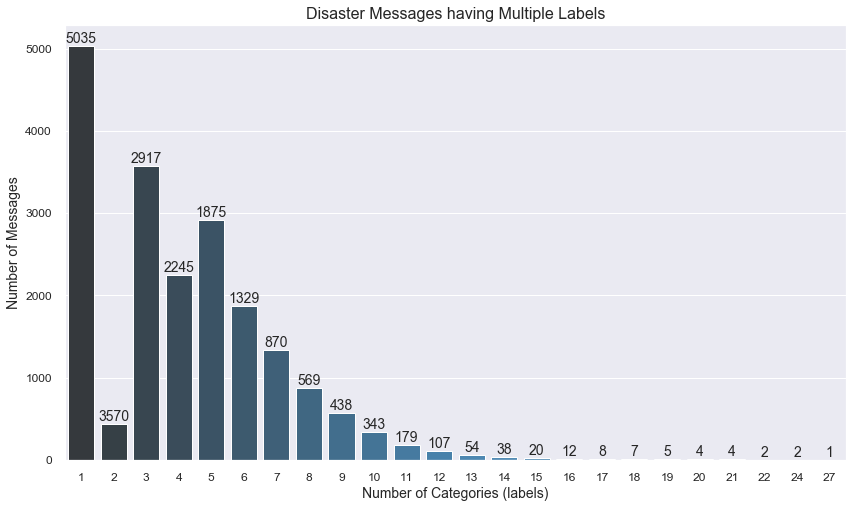

In [70]:
SMALL_SIZE = 12  # fontsize of the tick labels
rowSums = df_en[df_en.columns[4:]].iloc[:,:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale = 2)
plt.figure(figsize=(14,8))
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
ax = sns.barplot(x = multiLabel_counts.index, y = multiLabel_counts.values, palette="Blues_d", )
plt.title("Disaster Messages having Multiple Labels", fontsize=16)
plt.ylabel('Number of Messages', fontsize=14)
plt.xlabel('Number of Categories (labels)', fontsize=14) 

rects = ax.patches
labels = multiLabel_counts.values  # adding the text labels on bars
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)

plt.show()

As we can see for the cleaned dataset, there are a lot of disaster messages (label amount of 1 at 5035 messages, means having value 1 only as part of the 'related' category), not mapped to one or more of the specific disaster categories from 'request' up to 'cold'. Most categorised disaster messages are mapped to 2 additional specific categories (2917 messages).

The 'related' column including only the value 1 is normally useless, but for this project, we don't remove it. 

If this column would be removed, have in mind that for the prediction models we need all the messages which are mapped to the real detailed categories, means having at least one item value of 1 in their row. During model evaluation, the other 'detailed category unlabelled' disaster messages will lead to UndefinedMetricWarning's because of 0 values.

In [71]:
print("The final cleaned 'en' disaster messages dataset has {} data points with {} variables each.".format(*df_en.shape))

The final cleaned 'en' disaster messages dataset has 19634 data points with 40 variables each.


**As a summary,** let us have a look to the final pandas profiling report of this English disaster messages dataframe.

In [72]:
df_en.profile_report()

Because in the summary report, there are warnings 'message has a high cardinality: 19505 distinct values ',
and the whole number of observations is 19634; are there again duplicates in the cleaned dataframe?

In [73]:
# check number of duplicates
sum(df_en.duplicated())

0

Additionally we would have removed redundant columns and would have done more cleaning, the report would show, that there are English text messages which are the same, but their multi-label category mapping to 1 or 0 is different, therefore they are no duplicates. As an example, we have a look to the listed message about Port-au-Prince.

In [74]:
df_portauprince = df_en.query("message == '?? port au prince ?? and food. they need goverment aid and international aid thak you. god bless haiti'")
df_portauprince

,message,original,genre,lang_code,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
162,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct,en,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
163,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct,en,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
164,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct,en,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
165,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct,en,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
y = df_portauprince[df_portauprince.columns[5:]]
print(y.columns)
y.values

Index(['request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')


array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

So, as expected the multi-label category mapping is different. Which one is the best? We cannot judge, all seem valuable. Therefore these duplicate messages are still be part of the dataset.

<a id='3.'></a>
## 3. Load

### 3.1 Save the Clean Dataset into an `sqlite` Database
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [76]:
try:
    engine = create_engine('sqlite:///Disaster_Messages_engine.db')
    df_en.to_sql('Messages_Categories_table', engine, if_exists='replace', index=False)
except:
    print("The SQL database creation failed. No file 'Disaster_Messages_engine.db' has been created.")

### 3.2 Use This Notebook to Complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.

My note: the associated file is called `process_data.py` and not `etl_pipeline.py` !